# Query Census utilizing cell metadata ontologies 

This notebook demonstrates how to utilize the [CELLxGENE Ontology Guide](https://github.com/chanzuckerberg/cellxgene-ontology-guide/) API to leverage the ontological structure of Census cell metadata to perform flexible and succinct queries. For example, how to get all Census single cell for all T cells and their descendants.

The notebook focuses specifically on cell types, but the same principles can be used to any of the other metadata fields that utilize ontologies (e.g. tissue and developmental stage).

**IMPORTANT:** This tutorial requires [cellxgene-ontology-guide package](https://chanzuckerberg.github.io/cellxgene-ontology-guide/cellxgene_ontology_guide.html) version 1.0.0 or later.

**Contents**

1. Obtain all descendant terms of a cell type
1. Query Census for all descendant terms of a cell type

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).


## Obtain all descendant terms of a cell type

The [CELLxGENE Ontology Guide](https://github.com/chanzuckerberg/cellxgene-ontology-guide/) provides a programatic interface to access and and parse the ontologies used by CELLxGENE for its cell and gene metadata. You can perform basic ontological operations, for example obtaining all ascendants or descendants of a cell type according to the Cell Ontology (CL).

To learn more about all the capabilities of the CELLxGENE Ontology Guide, please visit its [API documentation](https://chanzuckerberg.github.io/cellxgene-ontology-guide/cellxgene_ontology_guide.html).

In this notebook we will showcase an example to obtain all descendants of muscle cells. Let's first load the API, open the Census and fetch its **dataset** schema version.

In [1]:
import warnings

import cellxgene_census
import scanpy as sc
from cellxgene_ontology_guide.ontology_parser import OntologyParser

warnings.filterwarnings("ignore")


with cellxgene_census.open_soma(census_version="latest") as census:
    census = cellxgene_census.open_soma(census_version="latest")
    census_info = census["census_info"]["summary"].read().concat().to_pandas()

census_info

,soma_joinid,label,value
0,0,census_schema_version,2.0.1
1,1,census_build_date,2024-05-20
2,2,dataset_schema_version,5.0.0
3,3,total_cell_count,115556140
4,4,unique_cell_count,60597966
5,5,number_donors_homo_sapiens,17651
6,6,number_donors_mus_musculus,4216


In [2]:
schema_version = census_info.iloc[2, 2]

Now we can instantiate an `OntologyParser` to access the appropriate ontology versions according the dataset schema version.

In [3]:
ontology_parser = OntologyParser(schema_version=schema_version)

The `OntologyParser` class has methods to parse any available ontology in CELLxGENE. 

Let's identify all the descendants of muscle cells.

In [4]:
muscle_cell = "CL:0000187"
mappings = ontology_parser.map_term_descendants([muscle_cell])

# top 5
mappings[muscle_cell][:5]

['CL:0000027', 'CL:0000192', 'CL:0000189', 'CL:0008046', 'CL:0000190']

## Query Census for all descendant terms of a cell type

Now that we have all descendant terms of muscle cells, we can utilize those directly in Census to fetch all single-cell data for the all-encompassing set of muscle cells and its descendants.

To keep it small we will limit the query to only muscle cells of eye and esophagus.

In [5]:
tissues = ["esophagus", "eye"]

with cellxgene_census.open_soma(census_version="2023-12-15") as census:
    census = cellxgene_census.open_soma(census_version="2023-12-15")
    value_filter = f"cell_type_ontology_term_id in {mappings[muscle_cell]} and tissue_general in {tissues} and is_primary_data == True"

    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        obs_value_filter=value_filter,
        obs_embeddings=["scvi"],
    )

In [6]:
adata

AnnData object with n_obs × n_vars = 33473 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi'

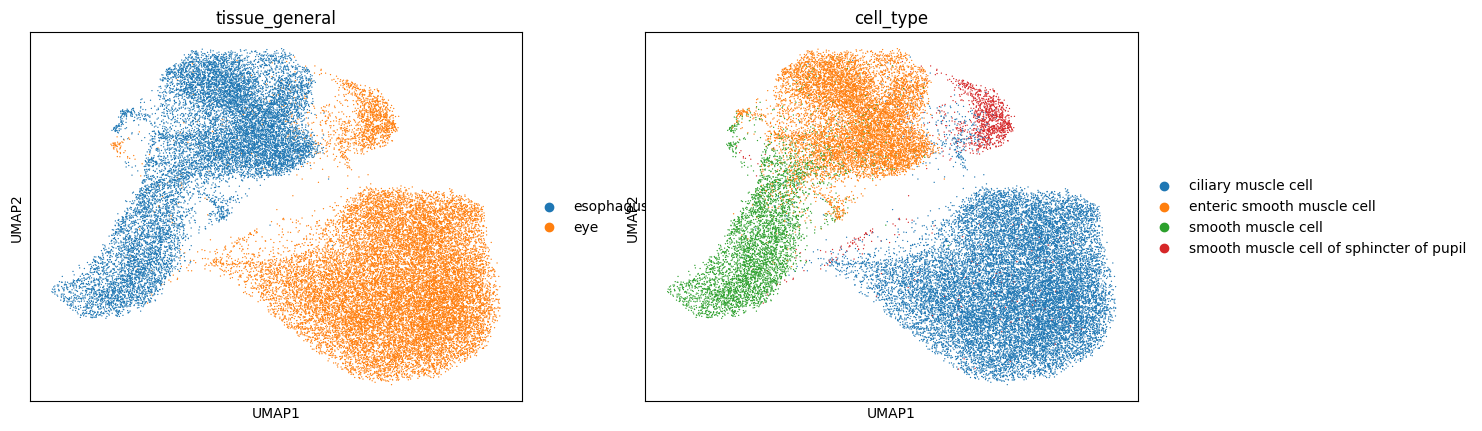

In [7]:
sc.pp.neighbors(adata, use_rep="scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["tissue_general", "cell_type"])